## 1. Introduction

In [1]:
# Libraries
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential

from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import (f_classif, SelectKBest)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import metrics

from imblearn.over_sampling import SMOTE

In [2]:
# Load data
fault = pd.read_csv('data/fault_data.csv', parse_dates=['DateTime'])
scada = pd.read_csv('data/scada_data.csv', parse_dates=['DateTime'])
status = pd.read_csv('data/status_data.csv', parse_dates=['Time'])

In [3]:
# Have a look at the fault dataset
fault.head(5)

,DateTime,Time,Fault
0,2014-05-14 14:39:44,1.400096e+09,GF
1,2014-05-14 14:50:24,1.400097e+09,GF
2,2014-05-14 14:58:56,1.400098e+09,GF
3,2014-05-14 15:09:36,1.400098e+09,GF
4,2014-05-14 15:20:16,1.400099e+09,GF


In [4]:
# Have a look at the scada dataset
scada.head(5)

,DateTime,Time,Error,WEC: ava. windspeed,WEC: max. windspeed,WEC: min. windspeed,WEC: ava. Rotation,WEC: max. Rotation,WEC: min. Rotation,WEC: ava. Power,...,Rectifier cabinet temp.,Yaw inverter cabinet temp.,Fan inverter cabinet temp.,Ambient temp.,Tower temp.,Control cabinet temp.,Transformer temp.,RTU: ava. Setpoint 1,Inverter averages,Inverter std dev
0,2014-05-01 00:00:00,1398920448,0,6.9,9.4,2.9,0.0,0.02,0.0,0,...,24,20,25,12,14,24,34,2501,25.272728,1.103713
1,2014-05-01 00:09:00,1398920960,0,5.3,8.9,1.6,0.0,0.01,0.0,0,...,24,20,25,12,14,24,34,2501,25.272728,1.103713
2,2014-05-01 00:20:00,1398921600,0,5.0,9.5,1.4,0.0,0.04,0.0,0,...,24,20,25,12,14,24,34,2501,25.272728,1.103713
3,2014-05-01 00:30:00,1398922240,0,4.4,8.3,1.3,0.0,0.08,0.0,0,...,23,21,25,12,14,24,34,2501,25.272728,1.103713
4,2014-05-01 00:39:00,1398922752,0,5.7,9.7,1.2,0.0,0.05,0.0,0,...,23,21,25,12,14,23,34,2501,25.272728,1.103713


In [5]:
# Have a look at the status dataset
status.head(5)

,Time,Main Status,Sub Status,Full Status,Status Text,T,Service,FaultMsg,Value0
0,2014-04-24 12:37:38,0,0,0 : 0,Turbine in operation,1,False,False,7.4
1,2014-04-25 19:27:24,71,104,71 : 104,Insulation monitoring : Insulation fault Phase U2,6,False,True,20.5
2,2014-04-26 09:30:13,8,0,8 : 0,Maintenance,6,True,False,17.1
3,2014-04-26 10:05:19,8,0,8 : 0,Maintenance,6,False,False,8.7
4,2014-04-26 10:05:25,8,0,8 : 0,Maintenance,6,True,False,10.6


## 2. Data Cleaning

### 2.1 Missing Values

In [6]:
# Check for na values
print('The number of entries containing missing values in the fault dataframe is: ', fault[fault.isnull().any(axis = 1)].shape[0])
print('The number of entries containing missing values in the scada dataframe is: ', scada[scada.isnull().any(axis = 1)].shape[0])
print('The number of entries containing missing values in the status dataframe is: ', status[status.isnull().any(axis = 1)].shape[0])

The number of entries containing missing values in the fault dataframe is:  0
The number of entries containing missing values in the scada dataframe is:  0
The number of entries containing missing values in the status dataframe is:  0


### 2.2 Duplicates

In [7]:
# Check for duplicate data
print('The number of duplicate rows in the fault dataframe is: ', sum(fault.duplicated()))
print('The number of duplicate rows in the scada dataframe is: ', sum(scada.duplicated()))
print('The number of duplicate rows in the status dataframe is: ', sum(status.duplicated()))

The number of duplicate rows in the fault dataframe is:  0
The number of duplicate rows in the scada dataframe is:  0
The number of duplicate rows in the status dataframe is:  0


### 2.3 Data types

In [8]:
# Check the data types of fault dataset
fault.dtypes

DateTime    datetime64[ns]
Time               float64
Fault               object
dtype: object

In [9]:
# Check the data types of scada dataset
scada.dtypes

DateTime                 datetime64[ns]
Time                              int64
Error                             int64
WEC: ava. windspeed             float64
WEC: max. windspeed             float64
                              ...      
Control cabinet temp.             int64
Transformer temp.                 int64
RTU: ava. Setpoint 1              int64
Inverter averages               float64
Inverter std dev                float64
Length: 66, dtype: object

In [10]:
# Check the data types of status dataset
status.dtypes

Time           datetime64[ns]
Main Status             int64
Sub Status              int64
Full Status            object
Status Text            object
T                       int64
Service                  bool
FaultMsg                 bool
Value0                float64
dtype: object

In [11]:
# Changing the type of 'Time' column from float to int, to be of same format as 'Time' in the 'scada' dataset - Unix Timestamp
fault.Time = fault.Time.astype(int)

In [12]:
# Rename column 'Time' to 'DateTime' in status dataframe to match the other two dataframes
status.rename({'Time' : 'DateTime'}, axis = 1, inplace = True)

# Rename columns 'Sub status', 'Main status', 'Full Status', 'Status Text' in status dataframe
status.rename({'Main Status' : 'MainStatus'}, axis = 1, inplace = True)
status.rename({'Sub Status' : 'SubStatus'}, axis = 1, inplace = True)
status.rename({'Full Status' : 'FullStatus'}, axis = 1, inplace = True)
status.rename({'Status Text' : 'StatusText'}, axis = 1, inplace = True)

## 3. Exploratory Data Analysis

### 3.1. Nominal attributes

In [13]:
fault_types = fault.groupby('Fault')

fault_types = fault_types.agg({'count'})['Time']

fault_types

,count
Fault,
AF,62
EF,174
FF,254
GF,43
MF,20


In [14]:
status_meaning = status.groupby(['StatusText', 'FullStatus'])

status_meaning = status_meaning.agg({'count'})['DateTime']

status_meaning

,,count
StatusText,FullStatus,
Air gap monitoring : Sensor 1 blade C,72 : 301,1
Cable twisted : Left (2-3 turns),21 : 1,1
Cable twisted : Right (2-3 turns),21 : 2,11
Calibration of load control,0 : 5,68
Data bus error (Timeout) : Fan inverter,304 : 56,1
Data bus error all inverters,204 : 0,5
Data bus error blade control (timeout) : Blade load control B,307 : 14,1
Excitation error : Overvoltage DC-link,80 : 21,84
Feeding control bus error (Bus-Off) : I/O-board control cabinet,301 : 81,3


In [15]:
# Fix Sub Status from 2 to 1 where Status Text = 'Lack of wind : Wind speed to low' 
status.loc[status.SubStatus == 2, 'SubStatus'] = 1
status.loc[status.FullStatus == '2 : 2', 'FullStatus'] = '2 : 1' # Change the value for FullStatus as well

# Fix Main Status from 66 to 62 (66 is the only value) and change 32 into 919 for Sub Status
status.loc[status.MainStatus == 66, 'MainStatus'] = 62
status.loc[status.SubStatus == 32, 'SubStatus'] = 919
status.loc[status.FullStatus == '66 : 32', 'FullStatus'] = '62 : 919' # Change the value for FullStatus as well

### 3.2. Time Series analysis

(0.0, 4.0)

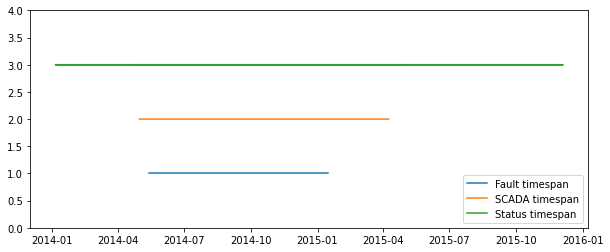

In [16]:
# Ploting the timespans
plt.figure(figsize = (10, 4))
plt.plot(fault.DateTime, np.full(len(fault), 1), label = 'Fault timespan')
plt.plot(scada.DateTime, np.full(len(scada), 2), label = 'SCADA timespan')
plt.plot(status.DateTime, np.full(len(status), 3), label = 'Status timespan')
plt.legend(loc = 'lower right')
plt.ylim(0, 4)

## 4. Data Preparation

### 4.1. Combining datasets

In [17]:
# Check how many matching datapoints are between 'scada' and 'status' datasets
scada_extended = scada.merge(status, on = 'DateTime', how = 'inner' )
scada_extended

,DateTime,Time,Error,WEC: ava. windspeed,WEC: max. windspeed,WEC: min. windspeed,WEC: ava. Rotation,WEC: max. Rotation,WEC: min. Rotation,WEC: ava. Power,...,Inverter averages,Inverter std dev,MainStatus,SubStatus,FullStatus,StatusText,T,Service,FaultMsg,Value0
0,2014-09-06,1409979648,0,2.700000,3.500000,2.2,5.71,6.11,5.43,29,...,31.272728,2.686667,228,100,228 : 100,Timeout warnmessage : Malfunction aircooling,6,False,True,9.4
1,2014-10-06,1412571648,0,17.799999,24.900000,8.8,14.16,15.09,12.75,3065,...,34.454544,1.863526,228,100,228 : 100,Timeout warnmessage : Malfunction aircooling,6,False,True,7.4
2,2014-11-06,1415253632,0,11.300000,15.700000,8.1,13.84,14.67,12.09,2816,...,28.363636,2.013590,228,100,228 : 100,Timeout warnmessage : Malfunction aircooling,6,False,True,7.5
3,2014-12-06,1417845632,0,7.400000,8.400000,6.2,10.16,10.85,9.66,903,...,21.363636,1.433368,228,100,228 : 100,Timeout warnmessage : Malfunction aircooling,6,False,True,3.7
4,2015-01-15,1421301632,0,13.000000,17.200001,9.4,14.69,15.04,14.18,2426,...,24.909090,1.814086,228,100,228 : 100,Timeout warnmessage : Malfunction aircooling,6,False,True,17.9
5,2015-01-16,1421388032,0,5.700000,7.200000,4.1,8.42,9.12,7.59,452,...,22.181818,3.188046,228,100,228 : 100,Timeout warnmessage : Malfunction aircooling,6,False,True,8.3


In [18]:
# Add 'fault' dataset to 'scada' creating the dataset will be used for analysis
data = scada.merge(fault, on = 'Time', how = 'outer')
data[-data.isna().any(axis = 1)]

,DateTime_x,Time,Error,WEC: ava. windspeed,WEC: max. windspeed,WEC: min. windspeed,WEC: ava. Rotation,WEC: max. Rotation,WEC: min. Rotation,WEC: ava. Power,...,Fan inverter cabinet temp.,Ambient temp.,Tower temp.,Control cabinet temp.,Transformer temp.,RTU: ava. Setpoint 1,Inverter averages,Inverter std dev,DateTime_y,Fault
1945,2014-05-14 14:39:00,1400096384,0,5.7,7.400000,4.1,9.98,10.23,9.72,0,...,27,17,26,35,34,2501,25.818182,0.603023,2014-05-14 14:39:44,GF
1946,2014-05-14 14:50:00,1400097024,0,6.4,8.600000,2.7,4.12,10.71,0.70,0,...,27,17,26,35,34,2501,26.090910,0.943880,2014-05-14 14:50:24,GF
1947,2014-05-14 14:58:00,1400097536,0,5.6,7.500000,4.0,9.99,10.20,9.80,0,...,27,17,26,35,34,2501,26.454546,0.820200,2014-05-14 14:58:56,GF
1948,2014-05-14 15:09:00,1400098176,0,5.3,6.600000,4.1,9.98,10.17,9.79,0,...,27,18,26,35,34,2501,26.181818,0.873863,2014-05-14 15:09:36,GF
1949,2014-05-14 15:20:00,1400098816,0,5.1,7.200000,3.8,9.99,10.17,9.80,0,...,28,18,26,35,34,2501,26.181818,0.981650,2014-05-14 15:20:16,GF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37075,2015-01-14 23:00:00,1421298048,0,13.5,22.000000,7.7,14.69,15.19,13.83,2736,...,24,8,29,35,57,3050,25.909090,1.814086,2015-01-14 23:00:48,AF
37076,2015-01-14 23:09:00,1421298560,0,15.5,25.700001,1.9,2.53,14.67,0.00,20,...,23,7,22,35,57,3050,28.181818,1.834022,2015-01-14 23:09:20,AF
37218,2015-01-15 22:50:00,1421383808,0,8.4,9.700000,6.8,12.79,13.30,11.64,1667,...,21,5,21,28,42,3050,20.909090,1.300350,2015-01-15 22:50:08,AF
37219,2015-01-15 23:00:00,1421384448,0,8.1,9.800000,6.0,11.71,13.27,9.99,1311,...,20,5,21,28,42,3050,20.909090,1.300350,2015-01-15 23:00:48,AF


In [19]:
# Delete data on time as timestamp is not an accepted data type for the following analysis
data = data.drop(columns = ['DateTime_x', 'Time', 'DateTime_y', 'Sys 2 inverter 6 cabinet temp.'])  # The last attribute is constant 0
data

,Error,WEC: ava. windspeed,WEC: max. windspeed,WEC: min. windspeed,WEC: ava. Rotation,WEC: max. Rotation,WEC: min. Rotation,WEC: ava. Power,WEC: max. Power,WEC: min. Power,...,Yaw inverter cabinet temp.,Fan inverter cabinet temp.,Ambient temp.,Tower temp.,Control cabinet temp.,Transformer temp.,RTU: ava. Setpoint 1,Inverter averages,Inverter std dev,Fault
0,0,6.9,9.4,2.9,0.00,0.02,0.00,0,0,0,...,20,25,12,14,24,34,2501,25.272728,1.103713,NaN
1,0,5.3,8.9,1.6,0.00,0.01,0.00,0,0,0,...,20,25,12,14,24,34,2501,25.272728,1.103713,NaN
2,0,5.0,9.5,1.4,0.00,0.04,0.00,0,0,0,...,20,25,12,14,24,34,2501,25.272728,1.103713,NaN
3,0,4.4,8.3,1.3,0.00,0.08,0.00,0,0,0,...,21,25,12,14,24,34,2501,25.272728,1.103713,NaN
4,0,5.7,9.7,1.2,0.00,0.05,0.00,0,0,0,...,21,25,12,14,23,34,2501,25.272728,1.103713,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49129,0,3.9,5.5,2.2,6.75,7.40,6.01,147,277,46,...,23,28,9,17,27,35,3050,24.454546,3.474583,NaN
49130,0,3.9,5.6,2.9,6.64,7.06,6.33,128,191,82,...,23,28,9,17,27,35,3050,24.454546,3.445683,NaN
49131,0,4.2,6.7,2.6,7.18,8.83,6.22,163,329,72,...,23,28,9,18,27,34,3050,24.363636,3.413876,NaN
49132,0,4.1,6.6,2.7,7.02,7.94,6.20,160,344,67,...,23,28,9,17,27,34,3050,24.000000,3.376389,NaN


In [20]:
# Change the missing values in 'Fault' attribute for the non-faulty entries from "NaN" as "NF" - Not Faulty
data['Fault'] = data['Fault'].replace(np.nan, 'NF')
data

,Error,WEC: ava. windspeed,WEC: max. windspeed,WEC: min. windspeed,WEC: ava. Rotation,WEC: max. Rotation,WEC: min. Rotation,WEC: ava. Power,WEC: max. Power,WEC: min. Power,...,Yaw inverter cabinet temp.,Fan inverter cabinet temp.,Ambient temp.,Tower temp.,Control cabinet temp.,Transformer temp.,RTU: ava. Setpoint 1,Inverter averages,Inverter std dev,Fault
0,0,6.9,9.4,2.9,0.00,0.02,0.00,0,0,0,...,20,25,12,14,24,34,2501,25.272728,1.103713,NF
1,0,5.3,8.9,1.6,0.00,0.01,0.00,0,0,0,...,20,25,12,14,24,34,2501,25.272728,1.103713,NF
2,0,5.0,9.5,1.4,0.00,0.04,0.00,0,0,0,...,20,25,12,14,24,34,2501,25.272728,1.103713,NF
3,0,4.4,8.3,1.3,0.00,0.08,0.00,0,0,0,...,21,25,12,14,24,34,2501,25.272728,1.103713,NF
4,0,5.7,9.7,1.2,0.00,0.05,0.00,0,0,0,...,21,25,12,14,23,34,2501,25.272728,1.103713,NF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49129,0,3.9,5.5,2.2,6.75,7.40,6.01,147,277,46,...,23,28,9,17,27,35,3050,24.454546,3.474583,NF
49130,0,3.9,5.6,2.9,6.64,7.06,6.33,128,191,82,...,23,28,9,17,27,35,3050,24.454546,3.445683,NF
49131,0,4.2,6.7,2.6,7.18,8.83,6.22,163,329,72,...,23,28,9,18,27,34,3050,24.363636,3.413876,NF
49132,0,4.1,6.6,2.7,7.02,7.94,6.20,160,344,67,...,23,28,9,17,27,34,3050,24.000000,3.376389,NF


In [21]:
# Lower number of instances with class 'NF' to 5000
data_nf = data[data.Fault == 'NF'].sample(5000, random_state = 123)
data_allF = data[data.Fault != 'NF']
data = pd.concat((data_nf, data_allF), axis = 0).reset_index(drop = True)
data

,Error,WEC: ava. windspeed,WEC: max. windspeed,WEC: min. windspeed,WEC: ava. Rotation,WEC: max. Rotation,WEC: min. Rotation,WEC: ava. Power,WEC: max. Power,WEC: min. Power,...,Yaw inverter cabinet temp.,Fan inverter cabinet temp.,Ambient temp.,Tower temp.,Control cabinet temp.,Transformer temp.,RTU: ava. Setpoint 1,Inverter averages,Inverter std dev,Fault
0,0,7.9,11.000000,5.2,11.02,12.71,9.69,1261,2027,721,...,21,26,10,20,27,36,3050,21.909090,1.300350,NF
1,0,4.8,5.900000,3.9,7.19,7.58,6.91,208,272,165,...,30,35,19,26,35,42,3050,31.272728,2.686667,NF
2,0,11.3,15.900000,8.3,14.06,14.80,13.23,2972,3146,2273,...,25,27,12,28,36,58,3050,28.818182,2.272364,NF
3,0,9.0,11.900000,6.1,12.32,13.73,10.03,1849,2718,835,...,22,25,11,20,27,35,3050,22.000000,1.341641,NF
4,0,11.6,15.900000,7.1,14.10,14.86,13.29,3006,3144,2325,...,27,30,16,28,36,54,3050,30.909090,2.385563,NF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5548,0,13.5,22.000000,7.7,14.69,15.19,13.83,2736,2798,2417,...,21,24,8,29,35,57,3050,25.909090,1.814086,AF
5549,0,15.5,25.700001,1.9,2.53,14.67,0.00,20,2746,0,...,21,23,7,22,35,57,3050,28.181818,1.834022,AF
5550,0,8.4,9.700000,6.8,12.79,13.30,11.64,1667,1914,1259,...,17,21,5,21,28,42,3050,20.909090,1.300350,AF
5551,0,8.1,9.800000,6.0,11.71,13.27,9.99,1311,1945,781,...,16,20,5,21,28,42,3050,20.909090,1.300350,AF


### 4.2 Binary classification dataset

In [22]:
# Create dataset for binary classification problem
data_bi = data.replace(['AF', 'EF', 'FF', 'GF', 'MF'], 'F') # All fault are now under the class 'F' - faulty
data_bi.head()

,Error,WEC: ava. windspeed,WEC: max. windspeed,WEC: min. windspeed,WEC: ava. Rotation,WEC: max. Rotation,WEC: min. Rotation,WEC: ava. Power,WEC: max. Power,WEC: min. Power,...,Yaw inverter cabinet temp.,Fan inverter cabinet temp.,Ambient temp.,Tower temp.,Control cabinet temp.,Transformer temp.,RTU: ava. Setpoint 1,Inverter averages,Inverter std dev,Fault
0,0,7.9,11.0,5.2,11.02,12.71,9.69,1261,2027,721,...,21,26,10,20,27,36,3050,21.909090,1.300350,NF
1,0,4.8,5.9,3.9,7.19,7.58,6.91,208,272,165,...,30,35,19,26,35,42,3050,31.272728,2.686667,NF
2,0,11.3,15.9,8.3,14.06,14.80,13.23,2972,3146,2273,...,25,27,12,28,36,58,3050,28.818182,2.272364,NF
3,0,9.0,11.9,6.1,12.32,13.73,10.03,1849,2718,835,...,22,25,11,20,27,35,3050,22.000000,1.341641,NF
4,0,11.6,15.9,7.1,14.10,14.86,13.29,3006,3144,2325,...,27,30,16,28,36,54,3050,30.909090,2.385563,NF


#### 4.2.1 Train Test split

In [23]:
# Split class from data
# Binary dataset
target_bi = data_bi.Fault
data_bi.drop('Fault', inplace = True, axis = 1)

In [24]:
# Splitting 'data_bi' dataset into training and testing sets
random.seed(123)
X_bi_train, X_bi_test, y_bi_train, y_bi_test = train_test_split(data_bi, target_bi, stratify = target_bi, test_size = 0.2)

print('Class destribution in train set: ', y_bi_train.value_counts(sort = True))
print('Class distribution in test set: ', y_bi_test.value_counts(sort = True))

Class destribution in train set:  NF    4000
F      442
Name: Fault, dtype: int64
Class distribution in test set:  NF    1000
F      111
Name: Fault, dtype: int64


#### 4.2.2 Standardization

In [25]:
# Defining standardization
sc = StandardScaler()

In [26]:
# Standardizing 'data_bi'
X_bi_train = sc.fit_transform(X_bi_train)
X_bi_test = sc.transform(X_bi_test)

### 4.3 Feature Engineering

In [27]:
# Retrieve numpy array from 'data_bi' and 'target_bi'
data_bi_array = data_bi.to_numpy()
target_bi_array = target_bi.to_numpy()

#### 4.3.1 ANOVA

In [28]:
random.seed(123)
# Feature extraction
anova_k32 = SelectKBest(score_func = f_classif, k = 32)
fit_anova_k32 = anova_k32.fit(data_bi_array, target_bi_array)

In [29]:
# Get columns to keep and create new dataframe with those only
cols = anova_k32.get_support(indices = True)
data_bi_anova = data.iloc[:,cols]

data_bi_anova

,WEC: ava. windspeed,WEC: max. windspeed,WEC: max. Rotation,WEC: ava. Power,WEC: max. Power,WEC: ava. reactive Power,WEC: max. reactive Power,WEC: ava. available P from wind,WEC: ava. available P technical reasons,WEC: ava. Available P force majeure reasons,...,Rotor temp. 1,Rotor temp. 2,Stator temp. 1,Stator temp. 2,Rectifier cabinet temp.,Control cabinet temp.,Transformer temp.,RTU: ava. Setpoint 1,Inverter averages,Inverter std dev
0,7.9,11.000000,12.71,1261,2027,106,160,1270,1270,1270,...,54,55,63,62,28,27,36,3050,21.909090,1.300350
1,4.8,5.900000,7.58,208,272,47,47,209,209,209,...,51,51,54,54,37,35,42,3050,31.272728,2.686667
2,11.3,15.900000,14.80,2972,3146,283,299,2985,2985,2985,...,106,106,98,97,28,36,58,3050,28.818182,2.272364
3,9.0,11.900000,13.73,1849,2718,168,244,1838,1838,1838,...,59,59,75,74,25,27,35,3050,22.000000,1.341641
4,11.6,15.900000,14.86,3006,3144,185,192,3002,3002,3002,...,90,89,100,99,30,36,54,3050,30.909090,2.385563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5548,13.5,22.000000,15.19,2736,2798,238,243,3014,2739,3014,...,82,82,114,113,27,35,57,3050,25.909090,1.814086
5549,15.5,25.700001,14.67,20,2746,4,241,2581,438,2581,...,71,70,104,104,27,35,57,3050,28.181818,1.834022
5550,8.4,9.700000,13.30,1667,1914,145,170,1675,1675,1675,...,56,56,77,77,23,28,42,3050,20.909090,1.300350
5551,8.1,9.800000,13.27,1311,1945,111,155,1317,1317,1317,...,53,53,75,75,23,28,42,3050,20.909090,1.300350


In [30]:
# Transform both training and testing sets
X_anova_train = anova_k32.transform(X_bi_train)
X_anova_test = anova_k32.transform(X_bi_test)

In [31]:
# Standardizing 'data_bi_anova'
X_anova_train = sc.fit_transform(X_anova_train)
X_anova_test = sc.transform(X_anova_test)

#### 4.3.2 Principal Components Analysis

In [32]:
random.seed(123)
# feature extraction
pca = PCA(0.95) # 95% Variance is maintained
fit_pca = pca.fit(X_bi_train)  # Standirdised training set
# summarize components
print("Explained Variance: %s" % fit_pca.explained_variance_ratio_)

Explained Variance: [0.39124955 0.25534272 0.09290357 0.04654446 0.03423839 0.03140134
 0.02377789 0.01801131 0.01695016 0.01467388 0.01358713 0.01074333
 0.00714317]


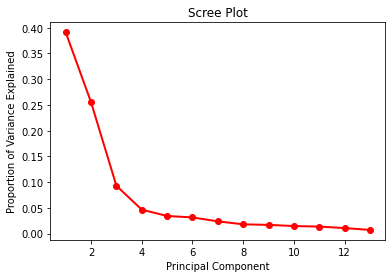

In [33]:
PC_values = np.arange(pca.n_components_) + 1
# Plot PCA
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

In [34]:
# Apply PCA on both training and testing sets
X_pca_train = pca.transform(X_bi_train)
X_pca_test = pca.transform(X_bi_test)

### 4.4 Class balancing - oversampling 

In [35]:
# SMOTE
sm = SMOTE(random_state = 123)

# Apply SMOTE on the binary classification dataset
data_bi_smote, target_bi_smote = sm.fit_resample(data_bi, target_bi)

#### 4.4.1 Train Test split

In [36]:
# Splitting 'data_bi_smote' dataset into training and testing sets
random.seed(123)
X_bi_smote_train, X_bi_smote_test, y_bi_smote_train, y_bi_smote_test = train_test_split(data_bi_smote, target_bi_smote, stratify = target_bi_smote, test_size = 0.2)

print('Class destribution in train set: ', y_bi_smote_train.value_counts(sort = True))
print('Class distribution in test set: ', y_bi_smote_test.value_counts(sort = True))

Class destribution in train set:  F     4000
NF    4000
Name: Fault, dtype: int64
Class distribution in test set:  F     1000
NF    1000
Name: Fault, dtype: int64


#### 4.4.2 Standardisation

In [37]:
# Standardizing 'data_bi_smote'
X_bi_smote_train = sc.fit_transform(X_bi_smote_train)
X_bi_smote_test = sc.transform(X_bi_smote_test)

## 5. Machine Learning - Fault Detection
### 5.1 Performance metrics

In [38]:
# Defining performance metrics
scores = ['f1_micro', 'accuracy', 'precision_micro', 'recall_micro']

### 5.2 Define models

In [39]:
# Support Vector Machine
model_svm = SVC(kernel = 'linear')

In [40]:
# Random Forest 
model_rf = RandomForestClassifier(n_estimators = 30, random_state = 300)

In [41]:
# Artificial Neural Network
model_ann = Sequential()
model_ann.add(Dense(32, input_dim = 54, activation = 'relu'))
model_ann.add(Dense(32, activation = 'relu'))
model_ann.add(Dense(1, activation = 'sigmoid'))

model_ann.summary()

model_ann.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model_ann.fit(X_bi_train, y_bi_train, epochs = 5)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                1760      
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,849
Trainable params: 2,849
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5


ValueError: in user code:

    File "c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 54), found shape=(None, 63)


### 5.3 Models fitting

In [42]:
# Binary classification dataset
# Support Vector Machine
random.seed(123)
svm_bi = model_svm.fit(X_bi_train, y_bi_train)
svm_predict_bi = model_svm.predict(X_bi_test)

# Random Forest
random.seed(123)
rf_bi = model_rf.fit(X_bi_train, y_bi_train)
rf_predict_bi = model_rf.predict(X_bi_test)

In [43]:
# Binary classification dataset with ANOVA
# Support Vector Machine
random.seed(123)
svm_bi_anova = model_svm.fit(X_anova_train, y_bi_train)
svm_predict_bi_anova = model_svm.predict(X_anova_test)

# Random Forest
random.seed(123)
rf_bi_anova = model_rf.fit(X_anova_train, y_bi_train)
rf_predict_bi_anova = model_rf.predict(X_anova_test)

In [44]:
# PCA Binary classification dataset
# Support Vector Machine
random.seed(123)
svm_bi_pca = model_svm.fit(X_pca_train, y_bi_train)
svm_predict_bi_pca = model_svm.predict(X_pca_test)

# Random Forest
random.seed(123)
rf_bi_pca = model_rf.fit(X_pca_train, y_bi_train)
rf_predict_bi_pca = model_rf.predict(X_pca_test)

In [45]:
# SMOTE binary classification dataset
# Support Vector Machine
random.seed(123)
svm_bi_smote = model_svm.fit(X_bi_smote_train, y_bi_smote_train)
svm_predict_bi_smote = model_svm.predict(X_bi_smote_test)

# Random Forest
random.seed(123)
rf_bi_smote = model_rf.fit(X_bi_smote_train, y_bi_smote_train)
rf_predict_bi_smote = model_rf.predict(X_bi_smote_test)

## 6. Evaluation
### 6.1 Accuracy

In [46]:
from sklearn.metrics import accuracy_score

print('Accuracy Score:')
print('Support Vector Machine:')
print('Binomial Classification dataset: ', accuracy_score(svm_predict_bi, y_bi_test))
print('Binomial Classification dataset with ANOVA f-test: ', accuracy_score(svm_predict_bi_anova, y_bi_test))
print('Binomial Classification dataset after PCA: ', accuracy_score(svm_predict_bi_pca, y_bi_test))
print('SMOTE Binomial Classification dataset: ', accuracy_score(svm_predict_bi_smote, y_bi_smote_test))

Accuracy Score:
Support Vector Machine:
Binomial Classification dataset:  0.9540954095409541
Binomial Classification dataset with ANOVA f-test:  0.9477947794779478
Binomial Classification dataset after PCA:  0.936993699369937
SMOTE Binomial Classification dataset:  0.9305


In [47]:
print('Random Forest:')
print('Binomial Classification dataset: ', accuracy_score(rf_predict_bi, y_bi_test))
print('Binomial Classification dataset with ANOVA f-test: ', accuracy_score(rf_predict_bi_anova, y_bi_test))
print('Binomial Classification dataset after PCA: ', accuracy_score(rf_predict_bi_pca, y_bi_test))
print('SMOTE Binomial Classification dataset: ', accuracy_score(rf_predict_bi_smote, y_bi_smote_test))

Random Forest:
Binomial Classification dataset:  0.9756975697569757
Binomial Classification dataset with ANOVA f-test:  0.9720972097209721
Binomial Classification dataset after PCA:  0.9702970297029703
SMOTE Binomial Classification dataset:  0.982


## 7. Machine Learning - Fault classification

In [48]:
# Split class from dataset

# Multiclass dataset
target = data.Fault
data.drop('Fault', inplace = True, axis = 1)
data

,Error,WEC: ava. windspeed,WEC: max. windspeed,WEC: min. windspeed,WEC: ava. Rotation,WEC: max. Rotation,WEC: min. Rotation,WEC: ava. Power,WEC: max. Power,WEC: min. Power,...,Rectifier cabinet temp.,Yaw inverter cabinet temp.,Fan inverter cabinet temp.,Ambient temp.,Tower temp.,Control cabinet temp.,Transformer temp.,RTU: ava. Setpoint 1,Inverter averages,Inverter std dev
0,0,7.9,11.000000,5.2,11.02,12.71,9.69,1261,2027,721,...,28,21,26,10,20,27,36,3050,21.909090,1.300350
1,0,4.8,5.900000,3.9,7.19,7.58,6.91,208,272,165,...,37,30,35,19,26,35,42,3050,31.272728,2.686667
2,0,11.3,15.900000,8.3,14.06,14.80,13.23,2972,3146,2273,...,28,25,27,12,28,36,58,3050,28.818182,2.272364
3,0,9.0,11.900000,6.1,12.32,13.73,10.03,1849,2718,835,...,25,22,25,11,20,27,35,3050,22.000000,1.341641
4,0,11.6,15.900000,7.1,14.10,14.86,13.29,3006,3144,2325,...,30,27,30,16,28,36,54,3050,30.909090,2.385563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5548,0,13.5,22.000000,7.7,14.69,15.19,13.83,2736,2798,2417,...,27,21,24,8,29,35,57,3050,25.909090,1.814086
5549,0,15.5,25.700001,1.9,2.53,14.67,0.00,20,2746,0,...,27,21,23,7,22,35,57,3050,28.181818,1.834022
5550,0,8.4,9.700000,6.8,12.79,13.30,11.64,1667,1914,1259,...,23,17,21,5,21,28,42,3050,20.909090,1.300350
5551,0,8.1,9.800000,6.0,11.71,13.27,9.99,1311,1945,781,...,23,16,20,5,21,28,42,3050,20.909090,1.300350


In [49]:
# Apply SMOTE to the multiclass dataset
data_smote, target_smote = sm.fit_resample(data, target)

### 7.1 Train and Test sets

In [50]:
# Splitting 'data_bi_smote' dataset into training and testing sets
random.seed(123)
X_smote_train, X_smote_test, y_smote_train, y_smote_test = train_test_split(data_smote, target_smote, stratify = target_smote, test_size = 0.2)

print('Class destribution in train set: ', y_smote_train.value_counts(sort = True))
print('Class distribution in test set: ', y_smote_test.value_counts(sort = True))

Class destribution in train set:  EF    4000
GF    4000
AF    4000
MF    4000
FF    4000
NF    4000
Name: Fault, dtype: int64
Class distribution in test set:  FF    1000
EF    1000
GF    1000
NF    1000
AF    1000
MF    1000
Name: Fault, dtype: int64


### 7.2 Standardization


In [51]:
# Standardizing 'data_smote' 
X_smote_train = sc.fit_transform(X_smote_train)
X_smote_test = sc.transform(X_smote_test)

### 7.3 Model fitting

In [52]:
# Random Forest
random.seed(123)
rf_smote = model_rf.fit(X_smote_train, y_smote_train)
rf_predict_smote = model_rf.predict(X_smote_test)

## 8. Evaluation

In [53]:
print('Accuracy of the SMOTE Binomial Classification dataset on Random Forest model: ', accuracy_score(rf_predict_smote, y_smote_test))

Accuracy of the SMOTE Binomial Classification dataset on Random Forest model:  0.9013333333333333


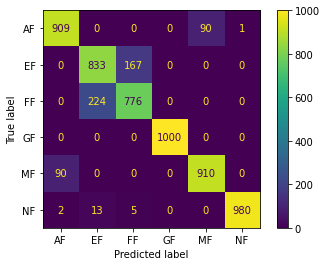

In [54]:
# Confusion Matrix
confusionMatrix = metrics.confusion_matrix(y_smote_test, rf_predict_smote)

confusionMatrix_display = metrics.ConfusionMatrixDisplay(confusionMatrix, display_labels = ['AF', 'EF', 'FF', 'GF', 'MF', 'NF'])

confusionMatrix_display.plot()
plt.show()